In [1]:
# Load relevant modules

#from tqdm.auto import tqdm
import sys
sys.path.append('../code/')
import source
import importlib
importlib.reload(source)
from source.catalog import CatalogASCII
from source.skymap import PlanckMap, SquarePatch
from source.cosmology import LambdaCDMCosmo
import astropy.units as au
from astropy.coordinates import Angle, SkyCoord
import healpy as hp
import numpy as np

import matplotlib
matplotlib.style.use('Minh_paper_style')
import matplotlib.pyplot as plt
from matplotlib.ticker import (FixedLocator, MultipleLocator, FixedFormatter, FormatStrFormatter,
                               AutoMinorLocator)

## Test matched filter on simulated square patch of observed CMB

Mean pixel std:
19.453005181919178
Mock primary CMB patch:
map mean: 0.0 map rms: 100.76276433085245


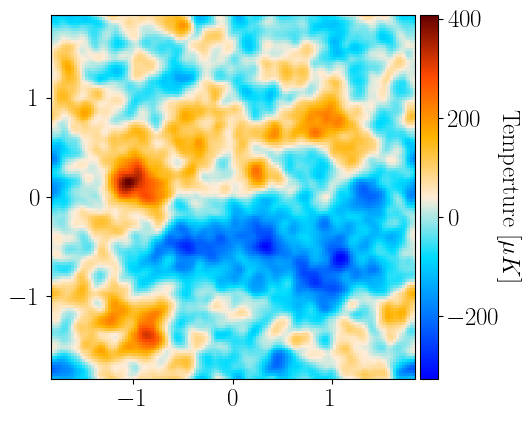

Mock instrumental noise patch:
map mean: -0.04575208670360358 map rms: 19.883594629454645


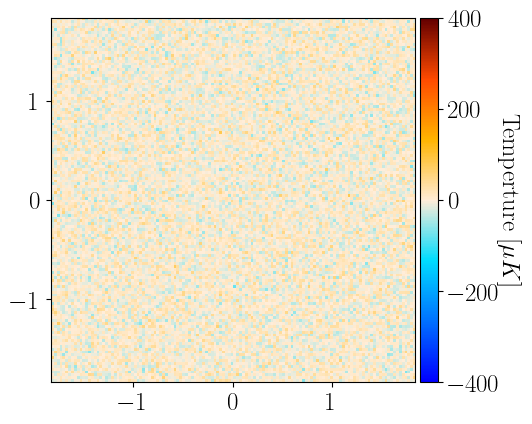

Mock SZ signal profile:
Central unconvolved SZ signal:
-283.5511375402833
map mean: -1.6286037038595644 map rms: 5.761568257951503


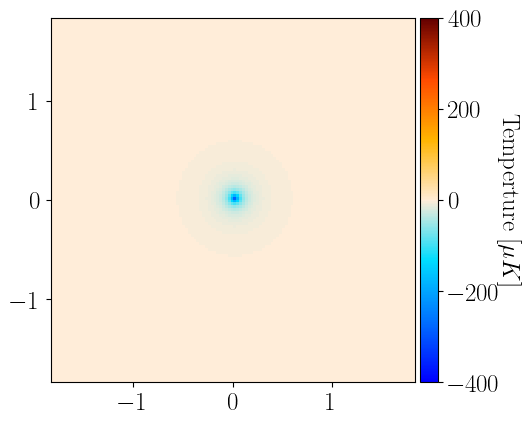

Mock observed CMB patch, all components included:
map mean: -1.674355790563169 map rms: 96.81270258708881


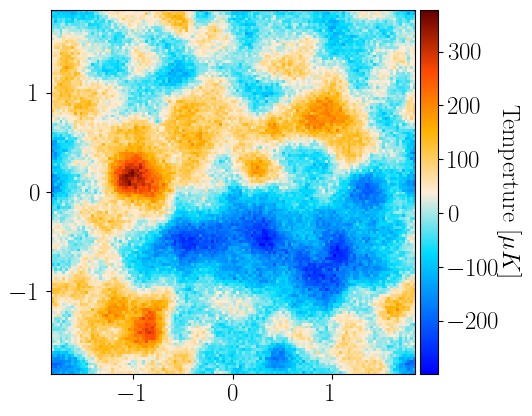

True

In [2]:
### Compute CMB + instrumental noise spectra

from source.cosmological_params import *
from source.map_params import *
# Set up the noise power spectrum
cosmo = LambdaCDMCosmo()
cosmo.get_Cl()
Bl = hp.gauss_beam(beam_size_fwhm.to_value(au.rad), lmax=camb_lmax_out)

II_Cov = hp.read_map('../data/cmb/observed_map/HFI_SkyMap_143_2048_R3.01_full.fits', field=4, dtype=np.float64)
II_Cov *= (au.Kelvin**2)
II_Cov = II_Cov.to_value(au.microKelvin**2).astype(np.float64)
sigma2_Nl =  np.mean(II_Cov)
print("Mean pixel std:")
print(np.mean(np.sqrt(II_Cov)))
Nl = np.ones_like(cosmo.CMBpower) * sigma2_Nl * ( (4.*np.pi) / hp.nside2npix(2048) )

#instrumental_noise_power_file = '../data/Cell_HFI143_DETnoise.npy'
#Nl = np.load(instrumental_noise_power_file)
Nl_expanded = np.zeros((camb_lmax_out+1,))
Nl_expanded[:Nl.shape[0]] = Nl
Nl_expanded[Nl.shape[0]:] = Nl[-1]

noise_Cl = (Bl**2)*cosmo.CMBpower+Nl_expanded

### Simulate full observed map, by adding all components together

# prepare the 2D grids
cmb_sim = SquarePatch(patch_array=np.zeros((n_pixels,n_pixels)))
ins_sim = SquarePatch(patch_array=np.zeros((n_pixels,n_pixels)))

# simulate noise components, primary CMB and instrumental noise
cmb_sim.simulate_CMB_patch(cosmo.CMBpower,seed=99)
ins_sim.simulate_CMB_patch(Nl_expanded,seed=2)
print("Mock primary CMB patch:")
cmb_sim.plot_patch(cmap_min=cmb_sim.map.min(),cmap_max=cmb_sim.map.max())
print("Mock instrumental noise patch:")
ins_sim.plot_patch()

# simulate tSZ signal
sz_sim = SquarePatch(patch_array=np.zeros((n_pixels,n_pixels)))
sz_sim.simulate_SZ_source_beta(SZ_beta,SZ_theta_core=2.*au.arcmin)
print("Mock SZ signal profile:")
print("Central unconvolved SZ signal:")
print(sz_sim.map[n_pixels//2,n_pixels//2])
sz_sim.plot_patch()

# combine CMB and tSZ
cmb_sim.stack(map2=sz_sim.map,weight=1.)

# convolve both with the beam
cmb_sim.convolve_gaussian(beam_size_fwhm=beam_size_fwhm)

# add instrumental noise
cmb_sim.stack(map2=ins_sim.map,weight=1.)
print("Mock observed CMB patch, all components included:")
cmb_sim.plot_patch(cmap_min=cmb_sim.map.min(),cmap_max=cmb_sim.map.max())

map mean: 1.6653345369377348e-16 map rms: 119.57012113990606


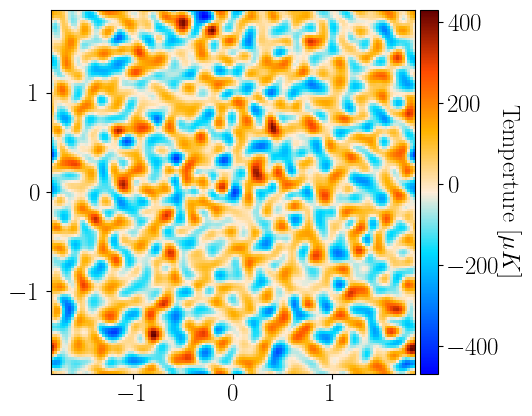

Central deconvolved tSZ signal:  -3.70e+02 muK_CMB
Sum deconvolved tSZ signal:  -3.18e+03 muK_CMB
Noise:  1.23e+02 muK_CMB
SNR:  -3.0023
(-0.23152399875290072+0j)
(0.9764032266421968+0j)


/usr/local/miniconda3/envs/sz-env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/miniconda3/envs/sz-env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


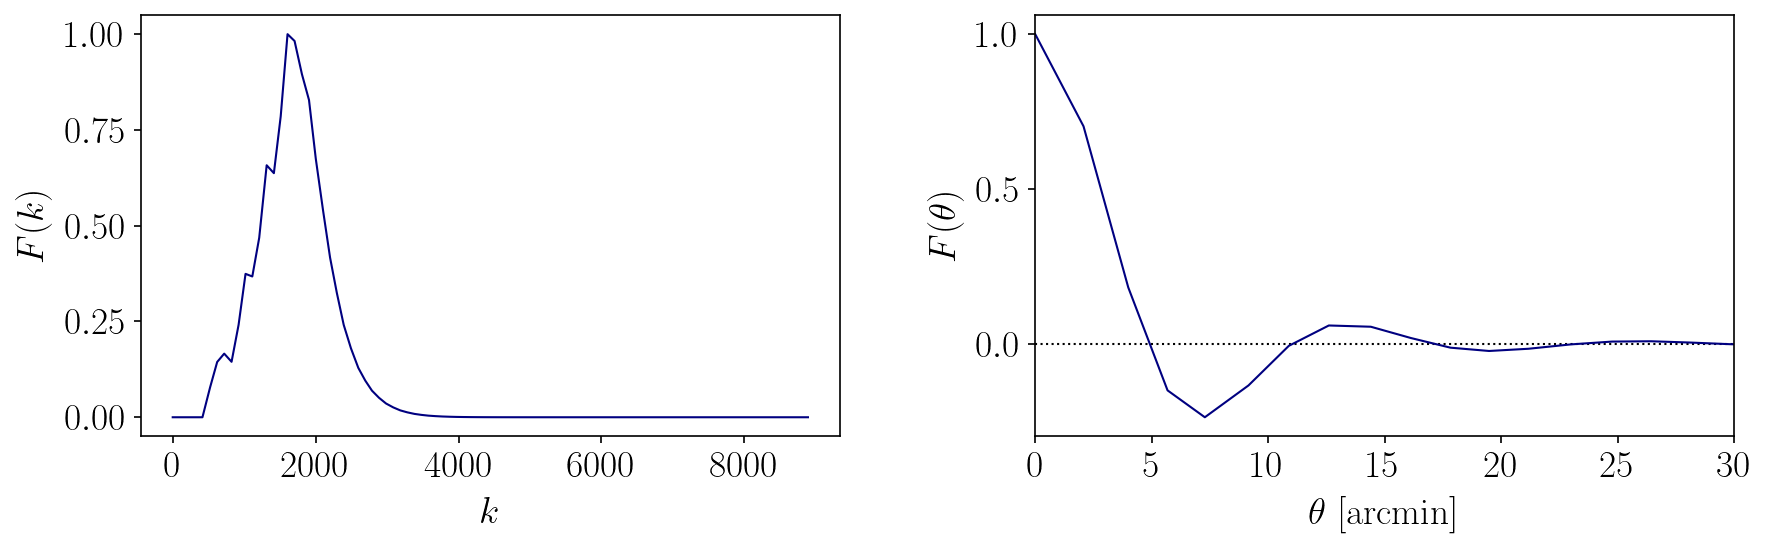

In [73]:
### Apply matched filter - theoretical noise estimate

# construct source profile, same as the one used for mock SZ signal above
source = sz_sim.get_beta_profile(0.5,SZ_theta_core=2.*au.arcmin)
source_profile = SquarePatch(patch_array=source)
source_profile.convolve_gaussian(beam_size_fwhm=beam_size_fwhm)

# actually apply the filter
m, mf_filter, mf_filter_noise = cmb_sim.apply_matched_filter(
    signal_profile=source_profile.map,
    noise_angular_power=noise_Cl,
    l0_taper=lowell_taper_pivot)

### Visual inspection of filtered map

filtered_patch = SquarePatch(patch_array=m)
filtered_patch.plot_patch(cmap_min=m.min(),cmap_max=m.max())
sum_signal=0.
center=(filtered_patch.map.shape[0]//2,filtered_patch.map.shape[1]//2)
sum_signal+=filtered_patch.map[center]
center=(filtered_patch.map.shape[0]//2-1,filtered_patch.map.shape[1]//2-1)
sum_signal+=filtered_patch.map[center]
center=(filtered_patch.map.shape[0]//2-1,filtered_patch.map.shape[1]//2)
sum_signal+=filtered_patch.map[center]
center=(filtered_patch.map.shape[0]//2,filtered_patch.map.shape[1]//2-1)
sum_signal+=filtered_patch.map[center]
center=(filtered_patch.map.shape[0]//2+1,filtered_patch.map.shape[1]//2+1)
sum_signal+=filtered_patch.map[center]
center=(filtered_patch.map.shape[0]//2+1,filtered_patch.map.shape[1]//2)
sum_signal+=filtered_patch.map[center]
center=(filtered_patch.map.shape[0]//2,filtered_patch.map.shape[1]//2+1)
sum_signal+=filtered_patch.map[center]
center=(filtered_patch.map.shape[0]//2-1,filtered_patch.map.shape[1]//2+1)
sum_signal+=filtered_patch.map[center]
center=(filtered_patch.map.shape[0]//2+1,filtered_patch.map.shape[1]//2-1)
sum_signal+=filtered_patch.map[center]
center=(filtered_patch.map.shape[0]//2,filtered_patch.map.shape[1]//2)
sum_signal+=filtered_patch.map[center]
print("Central deconvolved tSZ signal: ", '{:0.2e}'.format(filtered_patch.map[center]), "muK_CMB")
print("Sum deconvolved tSZ signal: ", '{:0.2e}'.format(sum_signal), "muK_CMB")
print("Noise: ", '{:0.2e}'.format(mf_filter_noise), "muK_CMB")
print("SNR: ", '{:0.4f}'.format(filtered_patch.map[center]/mf_filter_noise))

### Visual inspection of filter kernel

mf_kernel = (np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(mf_filter)))).real

# compute radial profiles of window and kernel. 
# the spatial frequency k has been computed using a conversion that allows a direct 
# comparison with the spherical multipole moment ell.

mf_kernel_patch = SquarePatch(patch_array=mf_kernel)
k, window = mf_kernel_patch.average_radial(abs(mf_filter), return_k=True)
theta, kernel = mf_kernel_patch.average_radial(mf_kernel, return_k=False)
pixel_size = (mf_kernel_patch.size[0].to_value(au.arcmin) / mf_kernel_patch.map.shape[0])

fig = plt.figure(figsize=(12,4), dpi=150)

plt.subplot(1,2,1)
plt.plot(k, window/window.max(),c='navy')
#plt.xlim(0.,2E4)
#plt.title(r"$\beta=0.86,\,\theta_c=2\mathrm{arcmin}$")
plt.xlabel(r"$k$")
plt.ylabel(r"$F(k)$")

plt.subplot(1,2,2)
plt.axhline(0.,ls=':',c='k')
plt.plot(theta*pixel_size, kernel/kernel.max(),c='navy')
print(np.min(kernel))
print(np.max(kernel))
plt.xlim(0.,30.)
plt.xticks(np.arange(0.,30.5,5.))
#plt.title("Filter kernel")
plt.xlabel(r"$\theta$ [arcmin]")
plt.ylabel(r"$F(\theta)$")
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.tight_layout()

map mean: 8.326672684688674e-17 map rms: 83.06374488398734


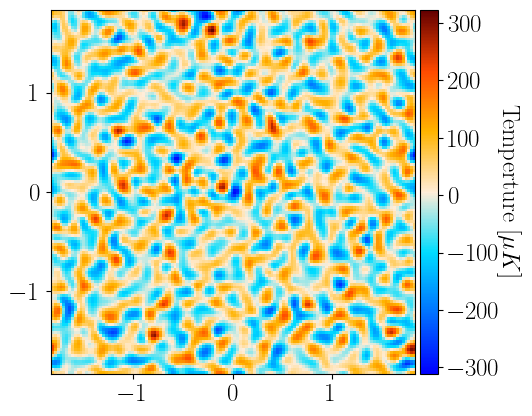

Central deconvolved tSZ signal:  -2.95e+02 muK_CMB
Noise:  8.43e+01 muK_CMB
SNR:  -3.5004
(-0.2080791810978677+0j)
(0.8538309263895393+0j)


/usr/local/miniconda3/envs/sz-env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/miniconda3/envs/sz-env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


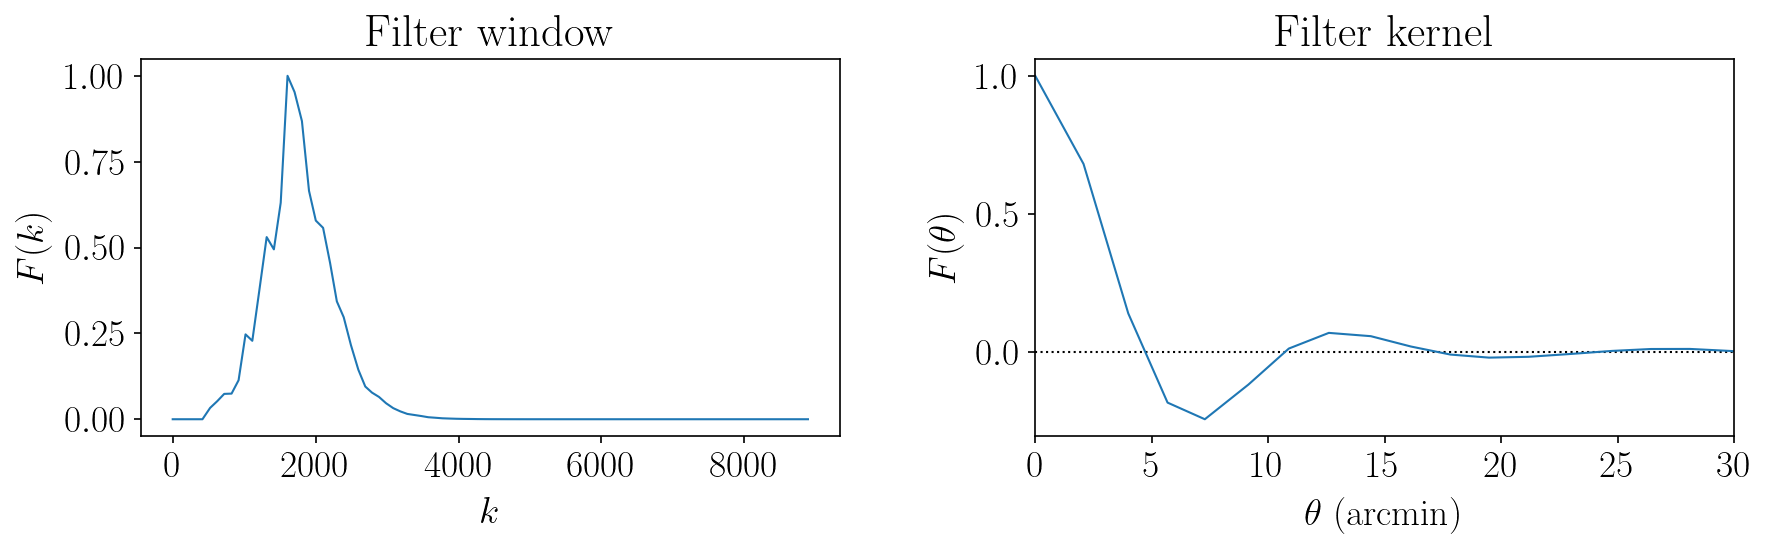

In [29]:
### Apply match filter - empirical noise estimate directly from the patch

# construct source profile, same as the one used for mock SZ signal above
source = sz_sim.get_beta_profile(SZ_beta,SZ_theta_core=2.*au.arcmin)
source_profile = SquarePatch(patch_array=source)
source_profile.convolve_gaussian(beam_size_fwhm=beam_size_fwhm)

# actually apply the filter
m, mf_filter, mf_filter_noise = cmb_sim.apply_matched_filter(
    signal_profile=source_profile.map,
    noise_angular_power=None,
    l0_taper=lowell_taper_pivot)

### Visual inspection of filtered map

filtered_patch = SquarePatch(patch_array=m)
filtered_patch.plot_patch(cmap_min=m.min(),cmap_max=m.max())
center=(filtered_patch.map.shape[0]//2,filtered_patch.map.shape[1]//2)
print("Central deconvolved tSZ signal: ", '{:0.2e}'.format(filtered_patch.map[center]), "muK_CMB")
print("Noise: ", '{:0.2e}'.format(mf_filter_noise), "muK_CMB")
print("SNR: ", '{:0.4f}'.format(filtered_patch.map[center]/mf_filter_noise))

### Visual inspection of filter kernel

mf_kernel = (np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(mf_filter)))).real

# compute radial profiles of window and kernel. 
# the spatial frequency k has been computed using a conversion that allows a direct 
# comparison with the spherical multipole moment ell.

mf_kernel_patch = SquarePatch(patch_array=mf_kernel)
k, window = mf_kernel_patch.average_radial(abs(mf_filter), return_k=True)
theta, kernel = mf_kernel_patch.average_radial(mf_kernel, return_k=False)
pixel_size = (mf_kernel_patch.size[0].to_value(au.arcmin) / mf_kernel_patch.map.shape[0])

fig = plt.figure(figsize=(12,4), dpi=150)

plt.subplot(1,2,1)
plt.plot(k, window/window.max())
#plt.xlim(0.,2E4)
plt.title("Window - beta profile")
plt.xlabel(r"$k$")
plt.ylabel(r"$F(k)$")

plt.subplot(1,2,2)
plt.axhline(0.,ls=':',c='k')
plt.plot(theta*pixel_size, kernel/kernel.max())
print(np.min(kernel))
print(np.max(kernel))
plt.xlim(0.,30.)
plt.xticks(np.arange(0.,30.5,5.))
plt.title("Filter kernel")
plt.xlabel(r"$\theta$ (arcmin)")
plt.ylabel(r"$F(\theta)$")
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.tight_layout()

## Test matched filter on square patch projected from a simulated full-sky map of CMB

/usr/local/miniconda3/lib/python3.6/site-packages/healpy/sphtfunc.py:438: FutureChangeWarning: The order of the input cl's will change in a future release.
Use new=True keyword to start using the new order.
See documentation of healpy.synalm.
  category=FutureChangeWarning,
/usr/local/miniconda3/lib/python3.6/site-packages/healpy/sphtfunc.py:824: UserWarning: Sigma is 0.000000 arcmin (0.000000 rad) 
  sigma * 60 * 180 / np.pi, sigma
/usr/local/miniconda3/lib/python3.6/site-packages/healpy/sphtfunc.py:829: UserWarning: -> fwhm is 0.000000 arcmin
  sigma * 60 * 180 / np.pi * (2.0 * np.sqrt(2.0 * np.log(2.0)))


map mean: -26.445403087801246 map rms: 86.19623735610597


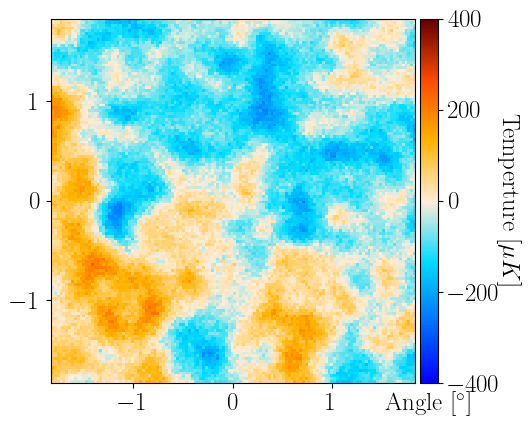

map mean: -4.440892098500626e-16 map rms: 123.34300158232021


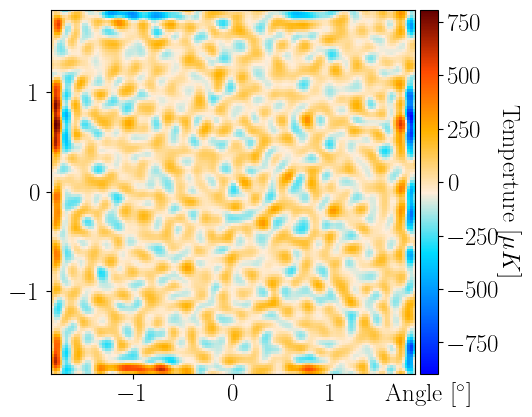

Central deconvolved tSZ signal:  -2.70e+02 muK_CMB
Noise:  8.62e+01 muK_CMB
SNR:  -3.1360
(-0.2098497689565096+0j)
(0.8677070941134293+0j)


/usr/local/miniconda3/lib/python3.6/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/miniconda3/lib/python3.6/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


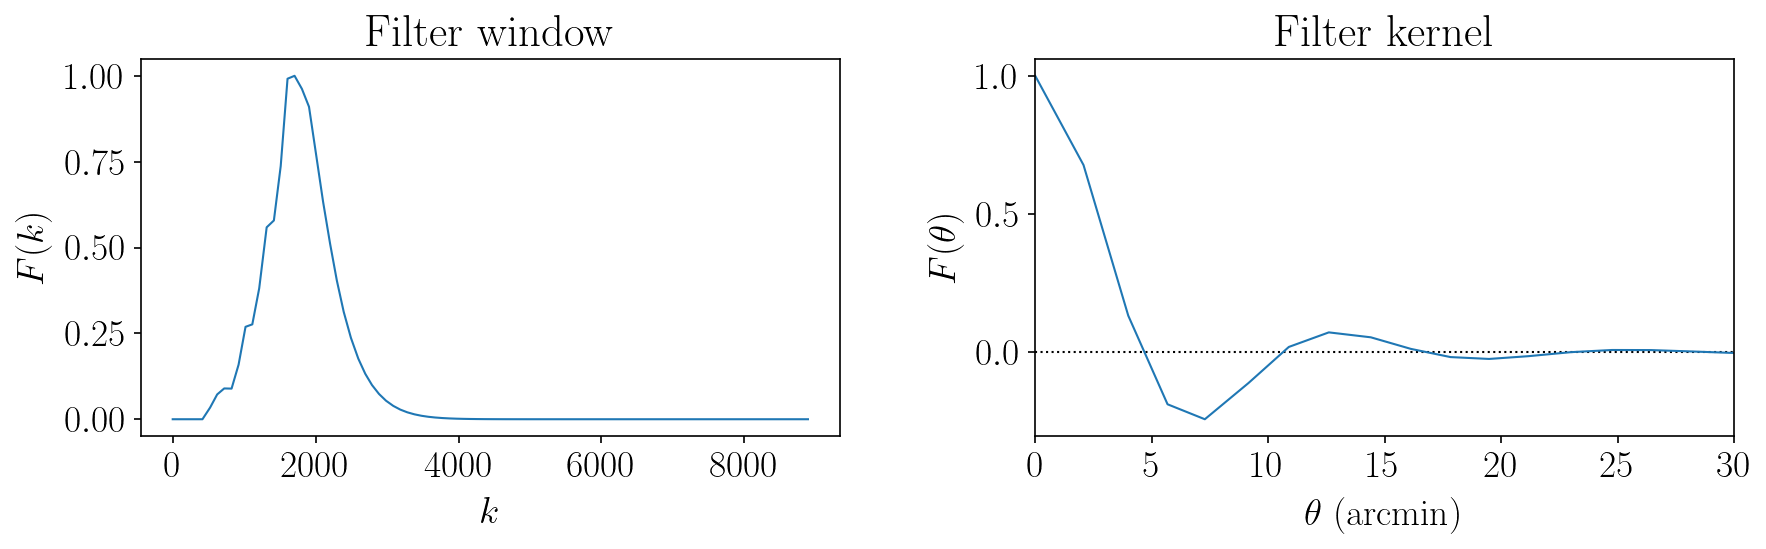

map mean: 4.440892098500626e-16 map rms: 117.95444100272437


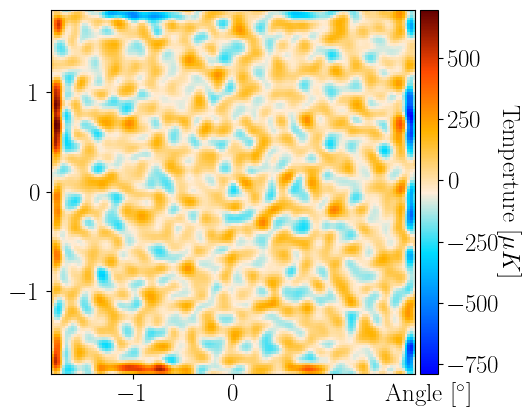

Central deconvolved tSZ signal:  -2.67e+02 muK_CMB
Noise:  1.19e+02 muK_CMB
SNR:  -2.2333
(-0.15095364144906506+0j)
(0.7471556562982383+0j)


/usr/local/miniconda3/lib/python3.6/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/miniconda3/lib/python3.6/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


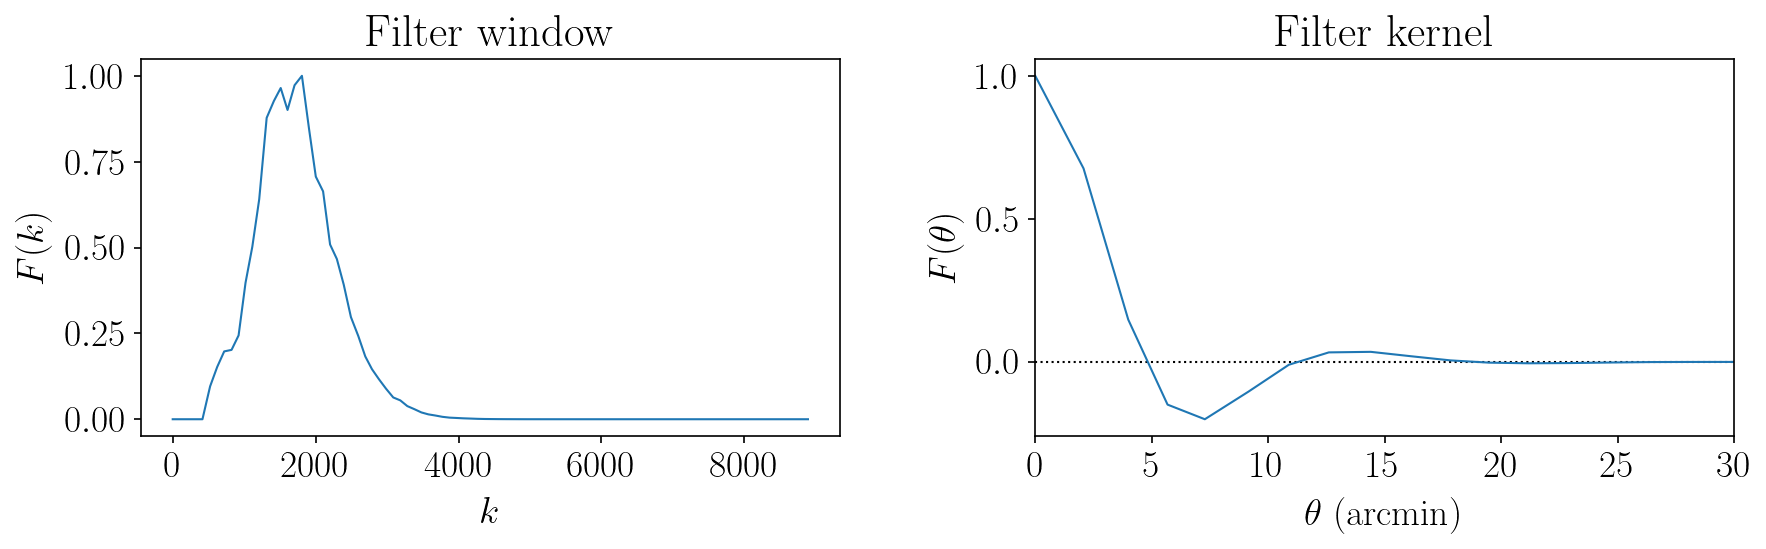

In [5]:
### Simulate full-sky observed CMB map

NSIDE=Planck_default_nside
np.random.seed(99)
fullsky_cmb = hp.synfast((Bl**2)*cosmo.CMBpower+Nl,nside=NSIDE)
mock_Planck_map = PlanckMap(map_array=fullsky_cmb,map_coord='C')

### Project to a square patch

ra=300. * au.deg
dec=15. * au.deg
cmb_patch = mock_Planck_map.get_Cartesian_square_patch(ra,dec,
            patch_size=patch_size,n_pixels=n_pixels,return_proj=False)
cmb_patch = SquarePatch(patch_array=cmb_patch,size_x=patch_size.to_value(au.deg),size_y=patch_size.to_value(au.deg))

### Inject SZ signal

sz_sim = SquarePatch(patch_array=np.zeros((n_pixels,n_pixels)),size_x=patch_size.to_value(au.deg),size_y=patch_size.to_value(au.deg))
sz_sim.simulate_SZ_source_beta(SZ_beta,SZ_theta_core=2.*au.arcmin)
sz_sim.convolve_gaussian(beam_size_fwhm=beam_size_fwhm)
cmb_patch.stack(weight=1.,map2=sz_sim.map)
cmb_patch.plot_patch()

### Apply matched filter - theoretical noise estimate

# construct source profile, same as the one used for mock SZ signal above
source = sz_sim.get_beta_profile(SZ_beta,SZ_theta_core=2.*au.arcmin)
source_profile = SquarePatch(patch_array=source,size_x=patch_size.to_value(au.deg),size_y=patch_size.to_value(au.deg))
source_profile.convolve_gaussian(beam_size_fwhm=beam_size_fwhm)

# actually apply the filter
m, mf_filter, mf_filter_noise = cmb_patch.apply_matched_filter(
    signal_profile=source_profile.map,
    noise_angular_power=noise_Cl,
    l0_taper=lowell_taper_pivot)

### Visual inspection of filtered map

filtered_patch = SquarePatch(patch_array=m)
filtered_patch.plot_patch(cmap_min=m.min(),cmap_max=m.max())
center=(filtered_patch.map.shape[0]//2,filtered_patch.map.shape[1]//2)
print("Central deconvolved tSZ signal: ", '{:0.2e}'.format(filtered_patch.map[center]), "muK_CMB")
print("Noise: ", '{:0.2e}'.format(mf_filter_noise), "muK_CMB")
print("SNR: ", '{:0.4f}'.format(filtered_patch.map[center]/mf_filter_noise))

### Visual inspection of filter kernel

mf_kernel = (np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(mf_filter)))).real

# compute radial profiles of window and kernel. 
# the spatial frequency k has been computed using a conversion that allows a direct 
# comparison with the spherical multipole moment ell.

mf_kernel_patch = SquarePatch(patch_array=mf_kernel)
k, window = mf_kernel_patch.average_radial(abs(mf_filter), return_k=True)
theta, kernel = mf_kernel_patch.average_radial(mf_kernel, return_k=False)
pixel_size = (mf_kernel_patch.size[0].to_value(au.arcmin) / mf_kernel_patch.map.shape[0])

fig = plt.figure(figsize=(12,4), dpi=150)

plt.subplot(1,2,1)
plt.plot(k, window/window.max())
#plt.xlim(0.,2E4)
plt.title("Filter window")
plt.xlabel(r"$k$")
plt.ylabel(r"$F(k)$")

plt.subplot(1,2,2)
plt.axhline(0.,ls=':',c='k')
plt.plot(theta*pixel_size, kernel/kernel.max())
print(np.min(kernel))
print(np.max(kernel))
plt.xlim(0.,30.)
plt.xticks(np.arange(0.,30.5,5.))
plt.title("Filter kernel")
plt.xlabel(r"$\theta$ (arcmin)")
plt.ylabel(r"$F(\theta)$")
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.tight_layout()
plt.show()

### Apply match filter - empirical noise estimate directly from the patch

# construct source profile, same as the one used for mock SZ signal above
source = sz_sim.get_beta_profile(SZ_beta,SZ_theta_core=2.*au.arcmin)
source_profile = SquarePatch(patch_array=source,size_x=patch_size.to_value(au.deg),size_y=patch_size.to_value(au.deg))
source_profile.convolve_gaussian(beam_size_fwhm=beam_size_fwhm)

# actually apply the filter
m, mf_filter, mf_filter_noise = cmb_patch.apply_matched_filter(
    signal_profile=source_profile.map,
    noise_angular_power=None,
    l0_taper=lowell_taper_pivot)

### Visual inspection of filtered map

filtered_patch = SquarePatch(patch_array=m)
filtered_patch.plot_patch(cmap_min=m.min(),cmap_max=m.max())
center=(filtered_patch.map.shape[0]//2,filtered_patch.map.shape[1]//2)
print("Central deconvolved tSZ signal: ", '{:0.2e}'.format(filtered_patch.map[center]), "muK_CMB")
print("Noise: ", '{:0.2e}'.format(mf_filter_noise), "muK_CMB")
print("SNR: ", '{:0.4f}'.format(filtered_patch.map[center]/mf_filter_noise))

### Visual inspection of filter kernel

mf_kernel = (np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(mf_filter)))).real

# compute radial profiles of window and kernel. 
# the spatial frequency k has been computed using a conversion that allows a direct 
# comparison with the spherical multipole moment ell.

mf_kernel_patch = SquarePatch(patch_array=mf_kernel)
k, window = mf_kernel_patch.average_radial(abs(mf_filter), return_k=True)
theta, kernel = mf_kernel_patch.average_radial(mf_kernel, return_k=False)
pixel_size = (mf_kernel_patch.size[0].to_value(au.arcmin) / mf_kernel_patch.map.shape[0])

fig = plt.figure(figsize=(12,4), dpi=150)

plt.subplot(1,2,1)
plt.plot(k, window/window.max())
#plt.xlim(0.,2E4)
plt.title("Filter window")
plt.xlabel(r"$k$")
plt.ylabel(r"$F(k)$")

plt.subplot(1,2,2)
plt.axhline(0.,ls=':',c='k')
plt.plot(theta*pixel_size, kernel/kernel.max())
print(np.min(kernel))
print(np.max(kernel))
plt.xlim(0.,30.)
plt.xticks(np.arange(0.,30.5,5.))
plt.title("Filter kernel")
plt.xlabel(r"$\theta$ (arcmin)")
plt.ylabel(r"$F(\theta)$")
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.tight_layout()
plt.show()

## Test the filter on stacked Planck HFI 143GHz map at locations of SZ-Union clusters

map mean: 0.0 map rms: 4.499617743145692


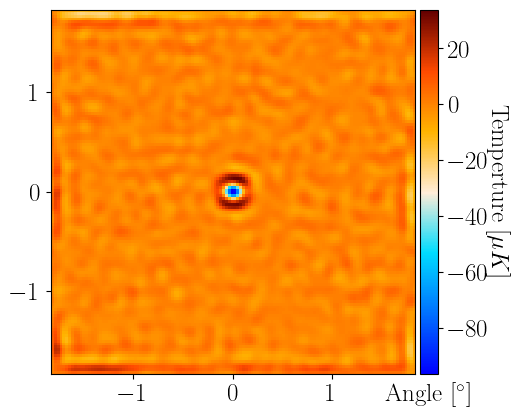

map mean: 0.0 map rms: 4.1910067048023025


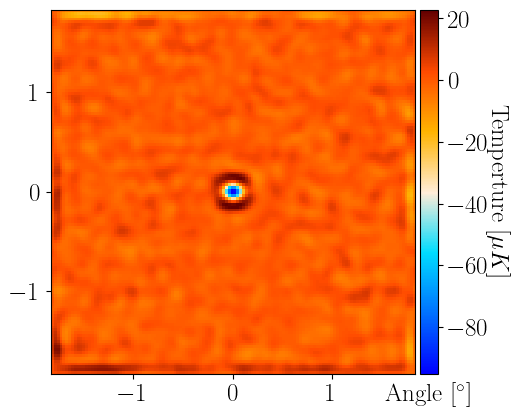

True

In [6]:
patches = np.load('../data/test_cmb_patches_HFI143_Planck_SZ-Union.npy')

stacked_patch = SquarePatch(patch_array=np.zeros((patches.shape[1],patches.shape[2])))
for p in range(patches.shape[0]):
    patch = patches[p,:,:]
    patch = SquarePatch(patch_array=patch)
    m, mf_filter, mf_filter_noise = patch.apply_matched_filter(
    source_profile.map,
    noise_angular_power=noise_Cl,
    l0_taper=lowell_taper_pivot)
    stacked_patch.stack(weight=1.,map2=m)
stacked_patch.map /= patches.shape[0]
stacked_patch.plot_patch(cmap_min=stacked_patch.map.min(),cmap_max=stacked_patch.map.max())

stacked_patch = SquarePatch(patch_array=np.zeros((patches.shape[1],patches.shape[2])))
for p in range(patches.shape[0]):
    patch = patches[p,:,:]
    patch = SquarePatch(patch_array=patch)
    m, mf_filter, mf_filter_noise = patch.apply_matched_filter(
    source_profile.map,
    noise_angular_power=None,
    l0_taper=200.)
    stacked_patch.stack(weight=1.,map2=m)
stacked_patch.map /= patches.shape[0]
stacked_patch.plot_patch(cmap_min=stacked_patch.map.min(),cmap_max=stacked_patch.map.max())